이제 cluster GCN 을 실제로 돌려보는 것으로 cluster GCN 이 어느정도의 성능을 보이는지를 살펴보겠다.

In [125]:
import networkx as nx
import pandas as pd
import itertools
import json
import os

import numpy as np

from networkx.readwrite import json_graph

from sklearn.preprocessing import StandardScaler

import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import GCN
from stellargraph import globalvar

from tensorflow.keras import backend as K

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
dataset = "cora"
G, labels = datasets.Cora().load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


실현용 dataset 으로는 `CORA` dataset 을 활용하였다. 해당 dataset 은 과학 계열 논문을 7개의 클래스로 분류해둔 것으로, 총 논문 (vertex) 의 숫자는 2708, 인용 network 의 edge 는 5429 개이다. 이때 각 dataset 에 포함된 각 논물들은 특정 단어를 포함하였는지의 여부에 대해 0/1 이라는 패러미터를 가진다. 이 특정 단어의 갯수는 총 1433 개이며, 따라서 각 vertex 는 1433 개의 패러미터를 가지고 있다. 

In [127]:
print(set(labels))

{'Reinforcement_Learning', 'Neural_Networks', 'Genetic_Algorithms', 'Rule_Learning', 'Case_Based', 'Theory', 'Probabilistic_Methods'}


`CORA` 의 topic 의 종류는 위의 7가지이다. 이제 `CORA` dataset으로 무작위 train 데이터셋을 만들어 cluster GCN 을 시작하였다. 이때 사전 cluster 의 갯수는 임의로 10으로 잡고, batch 당 합치는 cluster 의 갯수는 2로 설정하고 시작한다.

In [128]:
train_size = 140

train_labels, test_labels = model_selection.train_test_split(
    labels, train_size=train_size, test_size=None, stratify=labels
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=500, test_size=None, stratify=test_labels
)

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

number_of_clusters = 10  # the number of clusters/subgraphs
clusters_per_batch = 2  # combine two cluster per batch
random_clusters = True  # Set to False if you want to use METIS for clustering

node_ids = np.array(G.nodes())
clusters = number_of_clusters

generator = ClusterNodeGenerator(G, clusters=clusters, q=clusters_per_batch, lam=0.1)

Number of clusters 10
0 cluster has size 270
1 cluster has size 270
2 cluster has size 270
3 cluster has size 270
4 cluster has size 270
5 cluster has size 270
6 cluster has size 270
7 cluster has size 270
8 cluster has size 270
9 cluster has size 278


In [129]:
cluster_gcn = GCN(
    layer_sizes=[32, 32], 
    activations=["relu", "relu"], 
    generator=generator, 
    dropout=0.5
)

x_inp, x_out = cluster_gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

train_gen = generator.flow(train_labels.index, train_targets, name="train")
val_gen = generator.flow(val_labels.index, val_targets, name="val")

history = model.fit(
    train_gen, validation_data=val_gen, epochs=20, verbose=1, shuffle=False
)

Epoch 1/20
5/5 [==============================] - 0s 79ms/step - loss: 1.9015 - acc: 0.2429 - val_loss: 1.8175 - val_acc: 0.3120
Epoch 2/20
5/5 [==============================] - 0s 31ms/step - loss: 1.7459 - acc: 0.3143 - val_loss: 1.6510 - val_acc: 0.3140
Epoch 3/20
5/5 [==============================] - 0s 31ms/step - loss: 1.4995 - acc: 0.3714 - val_loss: 1.5109 - val_acc: 0.3600
Epoch 4/20
5/5 [==============================] - 0s 32ms/step - loss: 1.2963 - acc: 0.4929 - val_loss: 1.3540 - val_acc: 0.5200
Epoch 5/20
5/5 [==============================] - 0s 33ms/step - loss: 1.1286 - acc: 0.6214 - val_loss: 1.2043 - val_acc: 0.6020
Epoch 6/20
5/5 [==============================] - 0s 31ms/step - loss: 0.9003 - acc: 0.7000 - val_loss: 1.0739 - val_acc: 0.6580
Epoch 7/20
5/5 [==============================] - 0s 31ms/step - loss: 0.7154 - acc: 0.7429 - val_loss: 1.0287 - val_acc: 0.6360
Epoch 8/20
5/5 [==============================] - 0s 31ms/step - loss: 0.5635 - acc: 0.8000 - val

In [130]:
test_gen = generator.flow(test_labels.index, test_targets)
test_metrics = model.evaluate(test_gen)

predictions_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(predictions)

#predictions, predictions_flat

model_predict = Model(inputs=x_inp, outputs=predictions_flat)
all_nodes = list(G.nodes())
all_gen = generator.flow(all_nodes, name="all_gen")
all_predictions = model_predict.predict(all_gen)
node_predictions = target_encoding.inverse_transform(all_predictions)
results = pd.Series(node_predictions, index=all_gen.node_order)
df = pd.DataFrame({"Predicted": results, "True": labels})

x_out_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(x_out)
embedding_model = Model(inputs=x_inp, outputs=x_out_flat)
emb = embedding_model.predict(all_gen, verbose=1)

5/5 [==============================] - 0s 8ms/step


In [131]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

C:\Users\Song1\anaconda3\envs\stellargraph\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Song1\anaconda3\envs\stellargraph\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


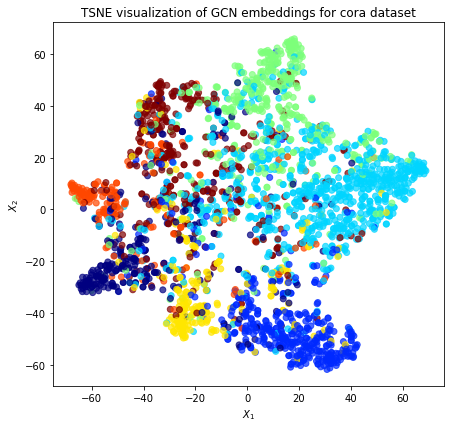

In [132]:
X = emb
y = np.argmax(
    target_encoding.transform(labels.reindex(index=all_gen.node_order)), axis=1,
)
if X.shape[1] > 2:
    transform = TSNE  # or use PCA for speed

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=all_gen.node_order)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GCN embeddings for cora dataset".format(transform.__name__)
)
plt.show()

해당 cluster-GCN 을 실제 데이터셋에 적용하여 결과를 확인한 바는 위와 같다. 분포가 다소 조밀하지 않은 중앙부위를 기점으로 각 방향으로 7가지 색깔의 cluster 가 구성되어 있음을 확인할 수 있다.  다소 섞여 있기는 하나 색깔별로 모여있는 양태를 볼 때 분류과정이 효과적으로 이루어졌다고 생각해도 무리는 없을 것이다. 특히 5000개의 데이터를 GCN 하는 과정에서 걸린 시간은 총합 약 600ms 로 시간적 측면에서 상당한 강점을 보임을 확인할 수 있다.